<a href="https://colab.research.google.com/github/PaprikaSteiger/CNN_GAN_tensorflow_vs_pytorch/blob/master/cnngan_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Implementing a CNNGAN with pytroch

## 1. Import and Preprocessing
### a) Importing modules

In [7]:
# Load required packages - data handling & plotting
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

# Load required packages - deep learning 
import torch
import torch.nn as nn
import torch.optim as optim

In [8]:
print(f"tensorflow: {torch.__version__}")
import sys
print(f"python: {sys.version[:5]}")

tensorflow: 1.8.1+cu101
python: 3.7.1


### b) Importing the data

In [9]:
# I exceeded my git LFS bandwidth limit for this month, thus the file cannot be loaded from git
#train_data = pd.read_csv('https://media.githubusercontent.com/media/PaprikaSteiger/CNN_GAN_tensorflow_vs_pytorch/master/fashion-mnist_train.csv')

# load directly from keras and transform to pandas
import tensorflow as tf
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
y_train = y_train.reshape((-1,1))
x_train = x_train.reshape((-1, 28*28))
x_train = np.concatenate([y_train, x_train], axis=1)
labels = ["label"] + [f"pixel{i}" for i in range(1,785)]
train_data = pd.DataFrame(x_train,columns=labels, index=list(range(60000)))
del x_train
del y_train
del x_test
del y_test

# or load from git repo from mmeirer
#train_data = pd.read_csv('https://media.githubusercontent.com/media/mmeierer/CNN---TensorFlow-vs-PyTorch/main/fashion-mnist_train.csv')

4423680/4422102 [==============================] - 0s 0us/step


In [10]:
train_data.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,...,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,1,0,0,0,0,41,188,103,54,48,43,87,168,133,16,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,49,136,219,216,...,244,240,243,214,224,162,0,2,0,0,0,0,0,0,0,0,0,1,0,0,139,146,130,135,135,137,125,124,125,121,119,114,130,76,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,22,118,24,0,0,0,0,0,48,88,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,12,100,212,...,106,102,75,10,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,18,42,57,56,32,8,0,0,1,0,0,0,0,0,0,0
3,3,0,0,0,0,0,0,0,0,33,96,175,156,64,14,54,137,204,194,102,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,73,186,177,183,175,...,83,152,85,160,133,100,12,0,0,0,0,0,0,0,0,0,0,0,4,0,2,0,35,4,33,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,26,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,189,206,187,...,255,242,255,70,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,61,102,168,25,0,139,161,74,0,0,0,0,0,0,0,0,0,0


In [11]:
train_images = train_data.iloc[:,1:]

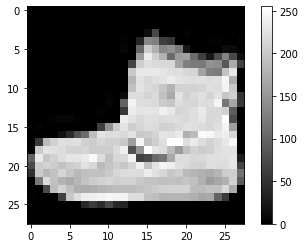

In [12]:
plt.figure()
plt.imshow(train_images.values[0].reshape(28,28), cmap='gray')
plt.colorbar()
plt.grid(False)
plt.show()

### c) Data preparation

In [13]:
# use maximum normalization
train_images = train_images / np.float32(255)

In [14]:
train_images.head()

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,pixel40,...,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.003922,0.0,0.0,0.000000,0.000000,0.160784,0.737255,0.403922,0.211765,0.188235,0.168627,0.341176,0.658824,0.521569,0.062745,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.003922,0.0,0.0,0.000000,0.192157,0.533333,0.858824,0.847059,0.894118,...,0.956863,0.941176,0.952941,0.839216,0.878431,0.635294,0.000000,0.007843,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.003922,0.000000,0.0,0.545098,0.572549,0.509804,0.529412,0.529412,0.537255,0.490196,0.486275,0.490196,0.474510,0.466667,0.447059,0.509804,0.298039,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.086275,0.462745,0.094118,0.000000,0.000000,0.000000,0.000000,0.000000,0.188235,0.345098,0.019608,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.047059,0.392157,0.831373,0.803922,...,0.415686,0.400000,0.294118,0.039216,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.003922,0.000000,0.000000,0.000000,0.070588,0.164706,0.223529,0.219608,0.125490,0.031373,0.000000,0.000000,0.003922,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.129412,0.376471,0.686275,0.611765,0.250980,0.054902,0.211765,0.537255,0.800000,0.760784,0.400000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.286275,0.729412,0.694118,0.717647,0.686275,0.737255,...,0.325490,0.596078,0.333333,0.627451,0.521569,0.392157,0.047059,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.015686,0.0,0.007843,0.000000,0.137255,0.015686,0.129412,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.101961,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.741176,0.807843,0.733333,0.125490,...,1.000000,0.949020,1.000000,0.274510,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.239216,0.400000,0.658824,0.098039,0.000000,0.545098,0.631373,0.290196,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0



## 2. Model specific data preparation (tensorflow)
## a) Load the data

In [15]:

x_train_pt = torch.from_numpy(train_images.values.reshape((-1, 1, 28, 28)))

### b) Tensor view of the data

In [16]:
x_train_pt.shape

torch.Size([60000, 1, 28, 28])

In [17]:
x_train_pt[0][0][5]

tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0235, 0.0000, 0.4000, 0.8000, 0.6902, 0.5255,
        0.5647, 0.4824, 0.0902, 0.0000, 0.0000, 0.0000, 0.0000, 0.0471, 0.0392,
        0.0000])

## 3. Model definition

In [110]:
def weights_init(m):
  classname = m.__class__.__name__
  if isinstance(m, nn.Linear):
      nn.init.uniform_(m.weight.data, -1,1)
      nn.init.zeros_(m.bias.data)
  #if isinstance(m, nn.Conv2d):
  #    nn.init.uniform_(m.weight.data, 0, 0.02)
  #    nn.init.zeros_(m.bias.data)
  #if isinstance(m, nn.ConvTranspose2d):
  #    nn.init.uniform_(m.weight.data, 0, 0.02)
  #    nn.init.zeros_(m.bias.data)
  if classname.find('Conv') != -1:
      nn.init.normal_(m.weight.data, 0.0, 0.02)
  elif classname.find('BatchNorm') != -1:
      nn.init.normal_(m.weight.data, 1.0, 0.02)
      nn.init.constant_(m.bias.data, 0)

class Reshape(nn.Module):
    def __init__(self, *args):
        super(Reshape, self).__init__()
        self.shape = args

    def forward(self, x):
        return x.view(self.shape)

### a.1) Generator

In [136]:
def generator_model():
    model = nn.Sequential()
    model.add_module("Conv2D1", nn.ConvTranspose2d(100, 64, 7, stride=1, padding=0, bias=True))
    #model.add_module("Batchnorm1", nn.BatchNorm2d(64))
    model.add_module("LeakyRelu1", nn.LeakyReLU())
    #model.add_module("Reshape", Reshape(-1, 64, 7, 7))
    
    model.add_module("Conv2D2", nn.ConvTranspose2d(64, 32, (8,8), stride=(1,1), padding=0, bias=True))
    #model.add_module("Batchnorm2", nn.BatchNorm2d(32))
    model.add_module("LeakyRelu2", nn.LeakyReLU())
    
    model.add_module("Conv2D3", nn.ConvTranspose2d(32, 1, (15,15), stride=1, padding=0, bias=True))
    #model.add_module("Batchnorm3", nn.BatchNorm2d(1))
    model.add_module("Sigmoid1", nn.Sigmoid())
    return model
generator = generator_model()

###  a.2) Inspect the generator model

In [80]:
print(generator)

Sequential(
  (Conv2D1): ConvTranspose2d(100, 64, kernel_size=(7, 7), stride=(1, 1))
  (Batchnorm1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (LeakyRelu1): LeakyReLU(negative_slope=0.01)
  (Conv2D2): ConvTranspose2d(64, 32, kernel_size=(8, 8), stride=(1, 1))
  (Batchnorm2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (LeakyRelu2): LeakyReLU(negative_slope=0.01)
  (Conv2D3): ConvTranspose2d(32, 1, kernel_size=(15, 15), stride=(1, 1))
  (Batchnorm3): BatchNorm1d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (Sigmoid1): Sigmoid()
)


In [137]:
generator.apply(weights_init)

Sequential(
  (Conv2D1): ConvTranspose2d(100, 64, kernel_size=(7, 7), stride=(1, 1))
  (LeakyRelu1): LeakyReLU(negative_slope=0.01)
  (Conv2D2): ConvTranspose2d(64, 32, kernel_size=(8, 8), stride=(1, 1))
  (LeakyRelu2): LeakyReLU(negative_slope=0.01)
  (Conv2D3): ConvTranspose2d(32, 1, kernel_size=(15, 15), stride=(1, 1))
  (Sigmoid1): Sigmoid()
)

In [138]:
# generated image not trained
fake_im_not_trained = generator(torch.normal(0, 1, size=[1, 100, 1, 1]))
# check output shape of generator
fake_im_not_trained

tensor([[[[0.5092, 0.5096, 0.5083, 0.5084, 0.5091, 0.5132, 0.5096, 0.5134,
           0.5132, 0.5132, 0.5181, 0.5088, 0.5086, 0.5116, 0.5161, 0.5161,
           0.5111, 0.5117, 0.5111, 0.5132, 0.5106, 0.5094, 0.5084, 0.5092,
           0.5113, 0.5105, 0.5099, 0.5099],
          [0.5097, 0.5095, 0.5084, 0.5092, 0.5138, 0.5164, 0.5145, 0.5164,
           0.5188, 0.5263, 0.5149, 0.5170, 0.5195, 0.5189, 0.5250, 0.5127,
           0.5224, 0.5214, 0.5136, 0.5192, 0.5119, 0.5184, 0.5067, 0.5100,
           0.5092, 0.5145, 0.5119, 0.5095],
          [0.5099, 0.5107, 0.5096, 0.5116, 0.5169, 0.5178, 0.5261, 0.5248,
           0.5183, 0.5257, 0.5142, 0.5256, 0.5128, 0.5183, 0.5288, 0.5253,
           0.5188, 0.5193, 0.5113, 0.5165, 0.5181, 0.5181, 0.5154, 0.5101,
           0.5101, 0.5131, 0.5111, 0.5108],
          [0.5111, 0.5135, 0.5133, 0.5136, 0.5227, 0.5241, 0.5192, 0.5193,
           0.5225, 0.5097, 0.5233, 0.5292, 0.5374, 0.5308, 0.5271, 0.5302,
           0.5259, 0.5330, 0.5389, 0.5085, 

### a.3) Inspect the first convolutional layer

In [24]:
generator[0].weight[0]

tensor([[[ 0.7009, -0.7041, -0.1102,  ..., -0.9771, -0.4857, -0.3781],
         [-0.6143,  0.4888,  0.6448,  ...,  0.0832,  0.8357,  0.6795],
         [ 0.4979, -0.8874, -0.8001,  ...,  0.9009,  0.9691,  0.3165],
         ...,
         [-0.6585, -0.0224, -0.1519,  ...,  0.1275, -0.2774, -0.0516],
         [-0.7280,  0.9821,  0.4851,  ..., -0.3166, -0.4248,  0.9474],
         [ 0.1445,  0.7119,  0.0860,  ...,  0.5282, -0.0927, -0.8238]],

        [[ 0.4253, -0.2040,  0.6886,  ...,  0.2422, -0.3324, -0.0418],
         [-0.3385,  0.2522, -0.0556,  ..., -0.6397, -0.4418, -0.7989],
         [-0.6277,  0.1049, -0.9963,  ..., -0.5462, -0.1564,  0.2832],
         ...,
         [-0.1146,  0.5828,  0.7325,  ...,  0.8839, -0.8728,  0.2547],
         [ 0.5764,  0.2741, -0.6448,  ...,  0.7589,  0.4808,  0.8759],
         [-0.2187, -0.5066,  0.6027,  ..., -0.5648, -0.2003, -0.3458]],

        [[ 0.7184, -0.5869,  0.6189,  ...,  0.3086,  0.9629,  0.1802],
         [ 0.1734, -0.7408, -0.1413,  ...,  0

In [26]:
generator[0].weight.shape

AttributeError: ignored

In [ ]:
generator[0].bias

In [ ]:
generator[0].bias.shape

### b.1) Discriminator

In [124]:
def discriminator_model():
    model = nn.Sequential()
    model.add_module("Conv2D1", nn.Conv2d(1, 2, kernel_size=5, stride=1, padding=2))
    model.add_module("Pooling1", nn.AvgPool2d(kernel_size=2, stride=2))
    model.add_module("LeakyRelu1", nn.LeakyReLU())
    model.add_module("Dropout1", nn.Dropout(0.3))
    
    model.add_module("Conv2D2", nn.Conv2d(2, 2, kernel_size=5, stride=1, padding=2))
    model.add_module("LeakyRelu2", nn.LeakyReLU())
    
    model.add_module("Conv2D3", nn.Conv2d(2, 1, kernel_size=5, stride=1, padding=0))
    model.add_module("LeakyRelu3", nn.LeakyReLU())
    
    model.add_module("Flatten1", nn.Flatten())
    
    model.add_module("Dense1", nn.Linear(100,100))
    model.add_module("LeakyRelu4", nn.LeakyReLU())
    
    model.add_module("Dense2", nn.Linear(100,64))
    model.add_module("Tanh", nn.Tanh())
    
    model.add_module("Dense3", nn.Linear(64,1))
    model.add_module("Sigmoid", nn.Sigmoid())
    return model
discriminator = discriminator_model()

### b.2) Inspect the discriminator model

In [28]:
print(discriminator)
discriminator(fake_im_not_trained)

Sequential(
  (Conv2D1): Conv2d(1, 2, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (Pooling1): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (LeakyRelu1): LeakyReLU(negative_slope=0.01)
  (Dropout1): Dropout(p=0.3, inplace=False)
  (Conv2D2): Conv2d(2, 2, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (LeakyRelu2): LeakyReLU(negative_slope=0.01)
  (Conv2D3): Conv2d(2, 1, kernel_size=(5, 5), stride=(1, 1))
  (LeakyRelu3): LeakyReLU(negative_slope=0.01)
  (Flatten1): Flatten(start_dim=1, end_dim=-1)
  (Dense1): Linear(in_features=100, out_features=100, bias=True)
  (LeakyRelu4): LeakyReLU(negative_slope=0.01)
  (Dense2): Linear(in_features=100, out_features=64, bias=True)
  (Tanh): Tanh()
  (Dense3): Linear(in_features=64, out_features=1, bias=True)
  (Sigmoid): Sigmoid()
)


tensor([[0.4946]], grad_fn=<SigmoidBackward>)

In [125]:
discriminator.apply(weights_init)

Sequential(
  (Conv2D1): Conv2d(1, 2, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (Pooling1): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (LeakyRelu1): LeakyReLU(negative_slope=0.01)
  (Dropout1): Dropout(p=0.3, inplace=False)
  (Conv2D2): Conv2d(2, 2, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (LeakyRelu2): LeakyReLU(negative_slope=0.01)
  (Conv2D3): Conv2d(2, 1, kernel_size=(5, 5), stride=(1, 1))
  (LeakyRelu3): LeakyReLU(negative_slope=0.01)
  (Flatten1): Flatten(start_dim=1, end_dim=-1)
  (Dense1): Linear(in_features=100, out_features=100, bias=True)
  (LeakyRelu4): LeakyReLU(negative_slope=0.01)
  (Dense2): Linear(in_features=100, out_features=64, bias=True)
  (Tanh): Tanh()
  (Dense3): Linear(in_features=64, out_features=1, bias=True)
  (Sigmoid): Sigmoid()
)

### b.3) Inspect the first convolutional layer

In [ ]:
discriminator[0].weight[0].type()

In [ ]:
discriminator[0].weight.shape

In [ ]:
discriminator[0].bias

In [ ]:
discriminator[0].bias.shape

## 4. Loss & Optimizer

### 4.a) Generator loss

In [126]:
cross_entropy = nn.BCEWithLogitsLoss()
def generator_loss(fake_output):
    return cross_entropy(torch.ones_like(fake_output), fake_output)

### 4.b) Discriminator loss

In [127]:
def real_discriminator_loss(real_output):
    return  cross_entropy(torch.ones_like(real_output), real_output)

def fake_discriminator_loss(fake_output):
    return cross_entropy(torch.zeros_like(fake_output), fake_output)

## 4.c) Optimizers

In [128]:
generator_optimizer = optim.Adam(generator.parameters(), lr=1e-3)
discriminator_optimizer = optim.Adam(discriminator.parameters(), lr=1e-3)

def correct_classification(y_true, y_prob):
    assert y_true.size() == y_prob.size()
    y_prob = (y_prob > 0.5).float()
    return (y_true == y_prob).sum().item()

## 5. Training

In [129]:
# This annotation causes the function to be "compiled".
#@tf.function
def train_step_pt(generator, discriminator, generator_optimizer, discriminator_optimizer, batch_size = 100):
    gen_loss_tot = []
    disc_loss_tot = []
    disc_acc_real_tot = 0
    disc_acc_fake_tot = 0
    generator.train()
    discriminator.train()
    for beg_i in range(0, x_train_pt.shape[0], batch_size):
        x_train_batch_pt = x_train_pt[beg_i:beg_i + batch_size]

        x_fake_batch_pt = torch.normal(0, 1, size=[batch_size, 100, 1, 1])
        
        discriminator_optimizer.zero_grad()
        real_output = discriminator(x_train_batch_pt.float()).view(-1)
        #disc_loss_real = cross_entropy(torch.full((batch_size,), 1, dtype=torch.float), real_output)
        disc_loss_real = real_discriminator_loss(real_output)
        disc_loss_real.backward()
        
        generated_images = generator(x_fake_batch_pt)
        fake_output = discriminator(generated_images.detach()).view(-1)
        #disc_loss_fake = cross_entropy(torch.full((batch_size,), 0, dtype=torch.float), fake_output)
        disc_loss_fake = fake_discriminator_loss(fake_output)
        disc_loss_fake.backward()
        err = disc_loss_fake + disc_loss_real
        discriminator_optimizer.step()
        
        # optimize generator
        generator_optimizer.zero_grad()
        fake_output = discriminator(generated_images.detach()).view(-1)
        #gen_loss= cross_entropy(torch.full((batch_size,), 1, dtype=torch.float), fake_output)
        gen_loss = generator_loss(fake_output)
        gen_loss.backward()
        generator_optimizer.step()
        
        gen_loss_tot.append(gen_loss.mean().item())
        disc_loss_tot.append(err.mean().item())
        disc_acc_real_tot += correct_classification(torch.ones_like(real_output), real_output)
        disc_acc_fake_tot += correct_classification(torch.zeros_like(fake_output), fake_output)

    disc_acc_real_tot = disc_acc_real_tot/x_train_pt.size(0)
    disc_acc_fake_tot = disc_acc_fake_tot/x_train_pt.size(0)
    print([disc_acc_real_tot, disc_acc_fake_tot])
    disc_acc_tot = np.mean([disc_acc_real_tot, disc_acc_fake_tot])
    return gen_loss_tot, disc_loss_tot, disc_acc_tot

In [131]:
train_losses_generator_pt = []
train_losses_discriminator_pt = []
train_acc_discriminator_pt = []
epochs = 15
start = time.time()
for epoch in range(epochs):
    gen_loss, disc_loss, disc_acc = train_step_pt(generator, discriminator, generator_optimizer, discriminator_optimizer)
    gen_loss = np.mean(gen_loss)
    disc_loss = np.mean(disc_loss)
    train_losses_generator_pt.append(gen_loss)
    train_losses_discriminator_pt.append(disc_loss)
    train_acc_discriminator_pt.append(disc_acc*100)


    template = ("Epoch {}, Loss_Generator: {}, Loss_Discriminator: {}, Discriminator_Accuracy: {}")
    print(template.format(epoch+1, gen_loss, disc_loss, disc_acc*100))
end = time.time()
print(f"Total training time{(end - start)/60.0}")

[1.0, 0.0]
Epoch 1, Loss_Generator: 0.3141033135354519, Loss_Discriminator: 1.0080019915103913, Discriminator_Accuracy: 50.0
[1.0, 0.0]
Epoch 2, Loss_Generator: 0.313262993345658, Loss_Discriminator: 1.0064100432395935, Discriminator_Accuracy: 50.0
[1.0, 0.0]
Epoch 3, Loss_Generator: 0.31326237464944523, Loss_Discriminator: 1.0064094837506612, Discriminator_Accuracy: 50.0


KeyboardInterrupt: ignored

In [ ]:
print(f"Total training time{(end - start)/60.0}")

### b) Training progress

In [ ]:
plt.figure(figsize=(16,10))
plt.plot(train_acc_discriminator_pt)
plt.title('discriminator accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['discriminator_train'], loc='upper right')
plt.show()

In [ ]:
plt.figure(figsize=(16,10))
plt.plot(train_losses_generator_pt)
plt.plot(train_losses_discriminator_pt)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['generator', 'discriminator'], loc='upper right')
plt.show()

### c1) Generator output before training

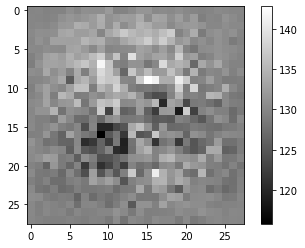

In [139]:

fake_im_not_trained = fake_im_not_trained.detach().numpy() * 255
fake_im_not_trained = fake_im_not_trained.reshape((28,28))
plt.figure()
plt.imshow(fake_im_not_trained, cmap='gray')
plt.colorbar()
plt.grid(False)
plt.show()

### c2) Generator output after training

In [ ]:
seed2 = torch.normal(0, 1, size=[1, 100, 1, 1])
generator.train(False)
fake_im = generator(seed2)
fake_im = fake_im.detach().numpy() * 255
fake_im = fake_im.reshape((28,28))
plt.figure()
plt.imshow(fake_im, cmap='gray')
plt.colorbar()
plt.grid(False)
plt.show()

## 6. References
The presented model is based on a combination of two tutorials for deep cnn-gans:
1) https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html

2) https://www.tensorflow.org/tutorials/generative/dcgan